# Evaluation of Lorenz GAN Models

The goal of this notebook is to evaluate the quality of the representation of the Lorenz 96 GAN parameterization.

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import keras.backend as K
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from keras.models import load_model
from lorenz_gan.gan import Interpolate1D
import pandas as pd
from scipy.stats import expon, lognorm
import pickle
from matplotlib.colors import LogNorm

In [27]:
def normalize_data(data, scaling_values=None):
    """
    Normalize each channel in the 4 dimensional data matrix independently.

    Args:
        data: 4-dimensional array with dimensions (example, y, x, channel/variable)
        scaling_values: pandas dataframe containing mean and std columns

    Returns:
        normalized data array, scaling_values
    """
    normed_data = np.zeros(data.shape, dtype=data.dtype)
    scale_cols = ["mean", "std"]
    if scaling_values is None:
        scaling_values = pd.DataFrame(np.zeros((data.shape[-1], len(scale_cols)), dtype=np.float32),
                                      columns=scale_cols)
    for i in range(data.shape[-1]):
        scaling_values.loc[i, ["mean", "std"]] = [data[:, :, i].mean(), data[:, :, i].std()]
        normed_data[:, :, i] = (data[:, :, i] - scaling_values.loc[i, "mean"]) / scaling_values.loc[i, "std"]
    return normed_data, scaling_values


def unnormalize_data(normed_data, scaling_values):
    """
    Re-scale normalized data back to original values

    Args:
        normed_data: normalized data
        scaling_values: pandas dataframe of mean and standard deviation from normalize_data

    Returns:
        Re-scaled data
    """
    data = np.zeros(normed_data.shape, dtype=normed_data.dtype)
    for i in range(normed_data.shape[-1]):
        data[:, :, i] = normed_data[:, :, i] * scaling_values.loc[i, "std"] + scaling_values.loc[i, "mean"]
    return data

def fit_condition_distributions(train_cond_data):
    """
    Calculate the scale parameter for the exponential distribution of correlated conditional variables
    for the Lorenz 96 model in time.

    Args:
        train_cond_data: array of conditioning values where the first column is the current X, and each
            other column is a lagged X value

    Returns:
        array of scale values
    """
    train_cond_exp_scale = np.zeros(train_cond_data.shape[1] - 1)
    for i in range(1, train_cond_data.shape[1]):
        train_cond_exp_scale[i - 1] = expon.fit(np.abs(train_cond_data[:, 0] - train_cond_data[:, i]), floc=0)[1]
    return train_cond_exp_scale


def generate_random_condition_data(batch_size, num_cond_inputs, train_cond_scale):
    """
    Generate correlated conditional random numbers to train the generator network.

    Args:
        batch_size: number of random samples
        num_cond_inputs: number of conditional inputs
        train_cond_scale: exponential distribution scale values

    Returns:

    """
    batch_cond_data = np.zeros((batch_size, num_cond_inputs, 1))
    batch_cond_data[:, 0, 0] = np.random.normal(size=batch_size)
    for t in range(1, train_cond_scale.size + 1):
        batch_cond_data[:, t , 0] = batch_cond_data[:, 0, 0] + \
                                    np.random.choice([-1, 1], size=batch_size) * expon.rvs(loc=0,
                                                                                           scale=train_cond_scale[t-1],
                                                                                           size=batch_size)
    return batch_cond_data

Load generator model

In [28]:
gan_samples = xr.open_dataset("../exp_u/gan_gen_patches_0000_epoch_0005.nc")
patches = gan_samples["gen_samples"][:, :, 0].values
gan_samples.close()

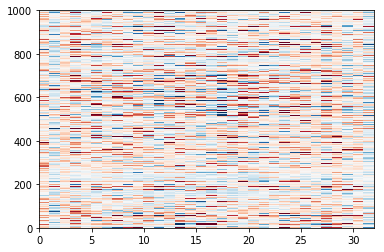

In [29]:
plt.pcolormesh(patches, vmin=-2, vmax=2, cmap="RdBu_r")

(array([   1.,    3.,    8.,   16.,   73.,  376.,  366.,  122.,   31.,    4.]),
 array([-2.55387282, -2.10217922, -1.65048561, -1.198792  , -0.7470984 ,
        -0.29540479,  0.15628881,  0.60798242,  1.05967603,  1.51136963,
         1.96306324]),
 <a list of 10 Patch objects>)

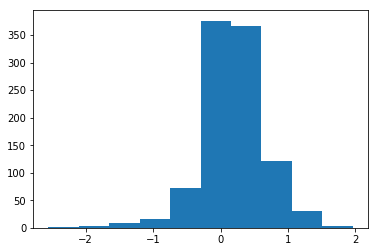

In [30]:
plt.hist(patches[:, 0])

(array([   8.,   42.,  117.,  186.,  273.,  190.,  113.,   45.,   18.,    8.]),
 array([-17.73592377, -12.95302162,  -8.17011948,  -3.38721733,
          1.39568481,   6.17858696,  10.96148911,  15.74439125,
         20.5272934 ,  25.31019554,  30.09309769]),
 <a list of 10 Patch objects>)

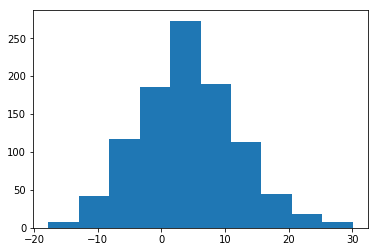

In [31]:
plt.hist(patches.sum(axis=1))

In [67]:
gan_loss = pd.read_csv("../exp_u/gan_loss_history_0000.csv", index_col="Time")
gan_loss["Epoch_Batch"] = gan_loss["Epoch"].values * gan_loss["Batch"].max() + gan_loss["Batch"].values
gan_loss["Epoch_Batch"] = gan_loss["Epoch_Batch"] / gan_loss["Epoch_Batch"].max() * gan_loss["Epoch"].max()

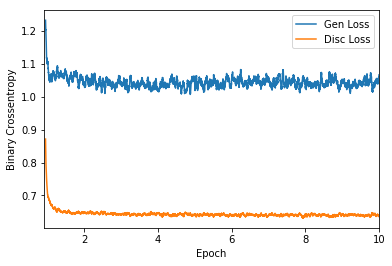

In [68]:

gan_loss[["Gen Loss", "Disc Loss"]].rolling(100).mean().plot(x=gan_loss["Epoch_Batch"].values)
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")

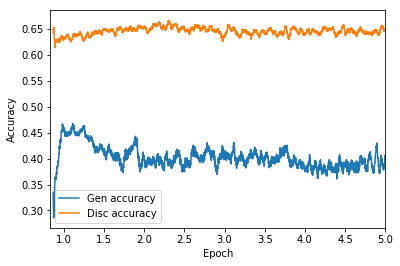

In [37]:
gan_loss[["Gen accuracy", "Disc accuracy"]].rolling(100).mean().plot(x=gan_loss["Epoch_Batch"].values)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Evaluate Generator Model

In [69]:
epoch = 10
gen_model = load_model("../exp_u/gan_generator_0000_epoch_{0:04d}.h5".format(epoch), custom_objects={"Interpolate1D": Interpolate1D})

(1, 8, 16)


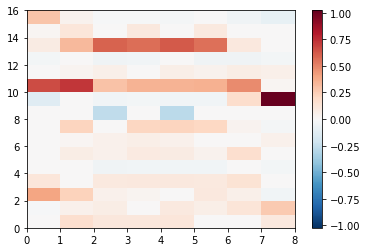

In [50]:
layer_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.layers[10].output])
out = layer_func([np.array([[-2, -1]]), np.array([[-2, -1, 0, 1, 3, 2, 1, .1]]), True])[0]
print(out.shape)
m_val = np.max(np.abs(out[0].T))
plt.pcolormesh(out[0].T, vmin=-m_val, vmax=m_val, cmap="RdBu_r")
plt.colorbar()

In [52]:
combined_data = pd.read_csv("../exp/lorenz_combined_output.csv")
y_cols = combined_data.columns[combined_data.columns.str.contains("Y")]
x_cols = combined_data.columns[combined_data.columns.str.contains("X")]
x_cols = ["X_t", 'U_t']
print(y_cols)
print(x_cols)

Index(['Y_0', 'Y_1', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_7', 'Y_8', 'Y_9',
       'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14', 'Y_15', 'Y_16', 'Y_17', 'Y_18',
       'Y_19', 'Y_20', 'Y_21', 'Y_22', 'Y_23', 'Y_24', 'Y_25', 'Y_26', 'Y_27',
       'Y_28', 'Y_29', 'Y_30', 'Y_31'],
      dtype='object')
['X_t', 'U_t']


In [53]:
x_norm, x_scaling = normalize_data(np.expand_dims(combined_data[x_cols].values, axis=-1))
y_norm, y_scaling = normalize_data(np.expand_dims(combined_data[y_cols].values, axis=-1))


In [70]:
pred_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
gan_norm = pred_func([x_norm[:,:,0] , np.random.normal(size=(x_norm.shape[0], 8)), True])[0]
gan_y = unnormalize_data(gan_norm, y_scaling)

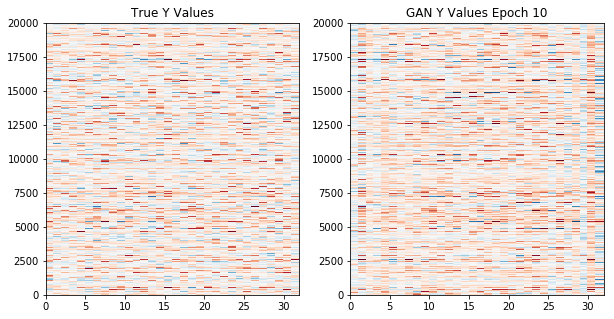

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(combined_data[y_cols].values[20000:40000], vmin=-2, vmax=2, cmap="RdBu_r")
axes[0].set_title("True Y Values")
axes[1].pcolormesh(gan_y[20000:40000, :, 0], vmin=-2, vmax=2, cmap="RdBu_r")
axes[1].set_title("GAN Y Values Epoch {0}".format(epoch))
plt.savefig("../exp/gan_y_vals_epoch_{0}.png".format(epoch), bbox_inches="tight", dpi=200)

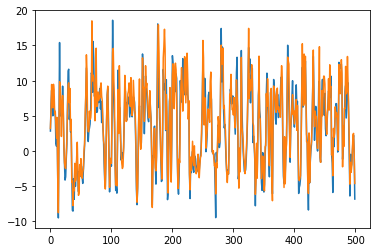

In [57]:
plt.plot(np.arange(0, 500), combined_data[y_cols].sum(axis=1).values[500:1000])
plt.plot(np.arange(0, 500), gan_y[:, :, 0].sum(axis=1)[500:1000])

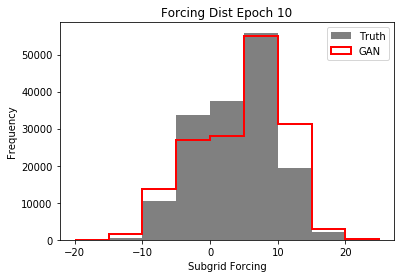

In [72]:
plt.hist(combined_data[y_cols].sum(axis=1).values, bins=np.arange(-20, 30, 5), color="gray", label="Truth")
plt.hist(gan_y[:, :, 0].sum(axis=1), bins=np.arange(-20, 30, 5), histtype='step', lw=2, label="GAN", color="red")
plt.legend()
plt.xlabel("Subgrid Forcing")
plt.ylabel("Frequency")
plt.title("Forcing Dist Epoch {0}".format(epoch))
plt.savefig("../exp/gan_subgrid_hist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


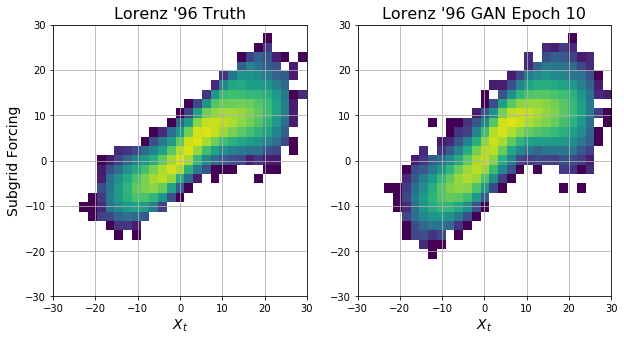

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                                   np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=10000, norm=LogNorm(1, 10000))
axes[0].set_title("Lorenz '96 Truth", fontsize=16)
_ = axes[1].hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
                                                                           np.linspace(-30, 30, 30)], 
                   cmin=1, cmax=10000, norm=LogNorm(1, 10000))
axes[1].set_title("Lorenz '96 GAN Epoch {0}".format(epoch), fontsize=16)
axes[0].set_xlabel("$X_t$", fontsize=14)
axes[1].set_xlabel("$X_t$", fontsize=14)
axes[0].grid()
axes[1].grid()
axes[0].set_ylabel("Subgrid Forcing", fontsize=14)
plt.savefig("../exp_u/gan_x_u_hist_epoch_{0}.png".format(epoch), dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6497: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


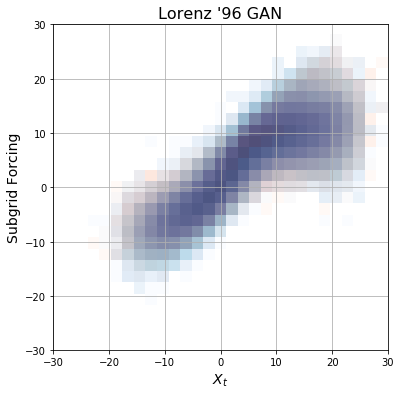

In [74]:
plt.figure(figsize=(6, 6))
_ = plt.hist2d(combined_data["X_t"], combined_data[y_cols].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmin=1, cmax=10000, norm=LogNorm(1, 10000), cmap="Reds", alpha=0.6)

_ = plt.hist2d(combined_data["X_t"], gan_y[:, :, 0].sum(axis=1), bins=[np.linspace(-30, 30, 30), 
               np.linspace(-30, 30, 30)], cmap="Blues", cmin=1, cmax=10000, norm=LogNorm(1, 10000), alpha=0.6)
plt.grid()
plt.title("Lorenz '96 GAN", fontsize=16)
plt.xlabel("$X_t$", fontsize=14)
plt.ylabel("Subgrid Forcing", fontsize=14)

In [63]:
y_data = combined_data[y_cols].values

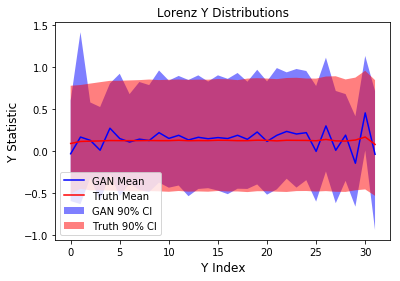

In [75]:
plt.fill_between(np.arange(32), np.percentile(gan_y[:, :, 0], 95, axis=0), 
                 np.percentile(gan_y[:, :, 0], 5, axis=0), alpha=0.5, label="GAN 90% CI", facecolor="blue")
plt.plot(gan_y[:, :, 0].mean(axis=0), label="GAN Mean", color="blue")
plt.fill_between(np.arange(32), np.percentile(y_data, 95, axis=0), 
                 np.percentile(y_data, 5, axis=0), alpha=0.5, facecolor="red", label="Truth 90% CI")
plt.plot(y_data.mean(axis=0), label="Truth Mean", color="red")
plt.legend(loc=3, fontsize=10)
plt.xlabel("Y Index", fontsize=12)
plt.ylabel("Y Statistic", fontsize=12)
plt.title("Lorenz Y Distributions")
plt.savefig("../exp/lorenz_y_dist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


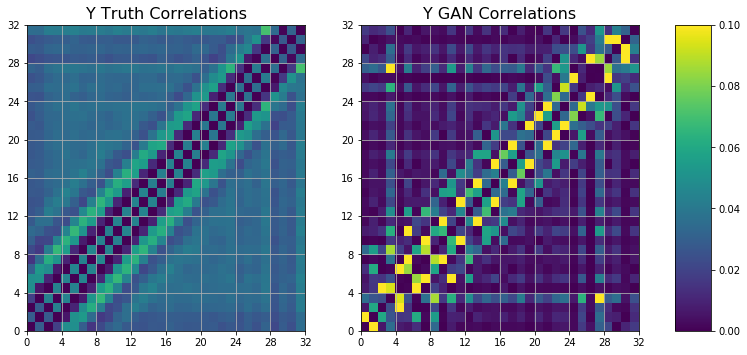

In [65]:
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(0.05, 0.05, 0.9, 0.9)
cax = fig.add_axes([0.95, 0.05, 0.05, .85])
truth_corr = np.corrcoef(y_data.T) **2
truth_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
gan_corr = np.corrcoef(gan_y[:, :, 0].T)**2
gan_corr[np.diag_indices(truth_corr.shape[0])] = np.nan
pc = axes[0].pcolormesh(truth_corr, vmin=0, vmax=0.1)
axes[1].pcolormesh(gan_corr, vmin=0, vmax=0.1)
axes[0].set_title("Y Truth Correlations", fontsize=16)
axes[0].set_xticks(np.linspace(0, 32, 9))
axes[1].set_xticks(np.linspace(0, 32, 9))
axes[0].set_yticks(np.linspace(0, 32, 9))
axes[1].set_yticks(np.linspace(0, 32, 9))
axes[0].grid()
axes[1].grid()
axes[1].set_title("Y GAN Correlations", fontsize=16)
plt.colorbar(pc, cax=cax)
plt.savefig("../exp/y_gan_correlations.png", dpi=200, bbox_inches="tight")

## Evaluate Lorenz GAN Forecast

The plots below show the different Lorenz GAN forecasts and how they compare with the truth run.

In [2]:
lorenz_data = xr.open_dataset("../exp/lorenz_output.nc")
x_vals = lorenz_data["lorenz_x"].values
lorenz_data.close()

In [76]:
num_members = 40
lorenz_gan_forecast_cube = np.zeros((num_members, 200, 8))
lorenz_poly_forecast_cube = np.zeros((num_members, 200, 8))
for i in range(num_members):
    lorenz_gan_file = xr.open_dataset("../exp_u/lorenz_forecast_{0:07d}_{1:02d}.nc".format(l_start, i))
    lorenz_gan_forecast_cube[i] = lorenz_gan_file["x"].values
    lorenz_gan_file.close()
    lorenz_poly_file = xr.open_dataset("../exp_poly/lorenz_forecast_{0:07d}_{1:02d}.nc".format(l_start, i))
    lorenz_poly_forecast_cube[i] = lorenz_poly_file["x"].values
    lorenz_poly_file.close()
    #lorenz_gan_forecast_cube[i] = pd.read_csv("../exp_u/lorenz_forecast_{0:02d}.csv".format(i)).iloc[:-1, 2:]
    #lorenz_hist_forecast_cube[i] = pd.read_csv("../exp_poly/lorenz_forecast_{0:02d}.csv".format(i)).iloc[:, 2:]

In [9]:
num_members = 40
lorenz_poly_forecast_cube_new = np.zeros((num_members, 200, 8))
lorenz_poly_forecast_cube_old = np.zeros((num_members, 200, 8))
l_start = 100000
for i in range(num_members):
    #lorenz_gan_forecast_cube[i] = pd.read_csv("../exp/lorenz_forecast_{0:02d}.csv".format(i)).iloc[:, 2:]
    lorenz_poly_file = xr.open_dataset("../exp_poly/lorenz_forecast_{0:07d}_{1:02d}.nc".format(l_start, i))
    lorenz_poly_forecast_cube_new[i] = lorenz_poly_file["x"].values
    lorenz_poly_file.close()
    lorenz_poly_file = xr.open_dataset("../exp_poly/lorenz_forecast_{0:02d}.nc".format(i))
    lorenz_poly_forecast_cube_old[i] = lorenz_poly_file["x"].values
    lorenz_poly_file.close()
    del lorenz_poly_file

In [77]:
l_start = 100000
l_end = l_start + 200
l_gan_fore_diff = np.zeros(lorenz_gan_forecast_cube.shape)
l_poly_fore_diff = np.zeros(lorenz_hist_forecast_cube.shape)
for i in range(num_members):
    l_gan_fore_diff[i] = lorenz_gan_forecast_cube[i] - x_vals[l_start:l_end]
    l_poly_fore_diff[i] = lorenz_poly_forecast_cube[i] - x_vals[l_start:l_end]

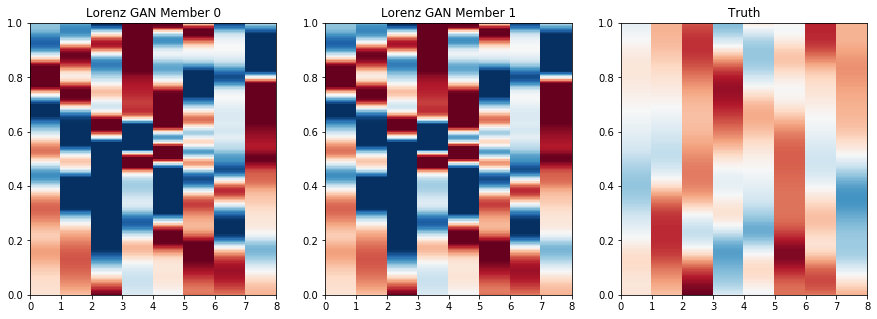

In [78]:
plt.figure(figsize=(15, 5))
mtu = np.arange(201) / 200
for i in range(2):
    plt.subplot(1,3, i + 1)
    plt.pcolormesh(np.arange(9), mtu, lorenz_gan_forecast_cube[i], vmin=-20, vmax=20, cmap="RdBu_r")
    plt.title("Lorenz GAN Member {0}".format(i))
plt.subplot(1, 3, 3)
plt.pcolormesh(np.arange(9), mtu,x_vals[100000:100000 + 200, :], vmin=-20, vmax=20, cmap="RdBu_r")
plt.title("Truth")

In [81]:
lorenz_gan_forecast_cube[0]

array([[  2.72155571,   5.86349964,  19.90745544, ...,  10.94618988,
         10.58712673,   7.072505  ],
       [  2.81753659,   6.30469656,  19.06028938, ...,  10.65804958,
         11.04477882,   6.7737999 ],
       [  2.97192359,   6.77936029,  17.99054527, ...,  10.35089111,
         11.59599209,   6.60087824],
       ..., 
       [ -8.15293312, -12.45246601, -16.18432808, ...,  15.22755051,
        -14.79994297, -10.97614479],
       [ -8.06043434, -11.85110855, -19.03351593, ...,  11.14178658,
        -16.47936821,  -9.01316261],
       [ -8.02703476, -11.08463383, -21.58555603, ...,   6.43724871,
        -17.548666  ,  -7.30212975]])

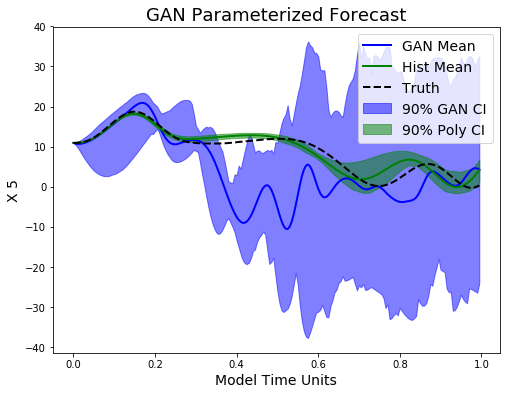

In [80]:
plt.figure(figsize=(8, 6))
x_val = 5
mtu = np.arange(200) / 200

plt.fill_between(mtu,
                 np.percentile(lorenz_gan_forecast_cube[:, :, x_val], 95, axis=0), 
                 np.percentile(lorenz_gan_forecast_cube[:, :, x_val], 5, axis=0), 
                 color="blue", alpha=0.5, label="90% GAN CI")
plt.plot(mtu, lorenz_gan_forecast_cube[:, :, x_val].mean(axis=0), color="blue", lw=2, label="GAN Mean")
plt.fill_between(mtu,
                 np.percentile(lorenz_poly_forecast_cube[:, :, x_val], 95, axis=0), 
                 np.percentile(lorenz_poly_forecast_cube[:, :, x_val], 5, axis=0), 
                 color="green", alpha=0.5, label="90% Poly CI")
plt.plot(mtu, lorenz_hist_forecast_cube[:, :, x_val].mean(axis=0), color="green", lw=2, label="Hist Mean")
plt.plot(mtu, x_vals[100000:100000 + 200, x_val], 'k--', lw=2, label="Truth")
plt.xlabel("Model Time Units", fontsize=14)
plt.ylabel("X {0:d}".format(x_val), fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.title("GAN Parameterized Forecast", fontsize=18)
plt.savefig("../exp/lorenz_forecast_ts.png", dpi=200, bbox_inches="tight")

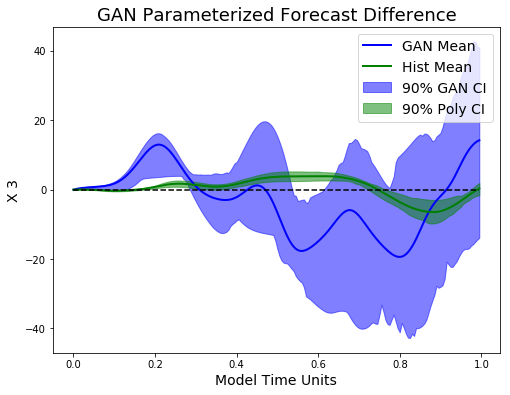

In [19]:
plt.figure(figsize=(8, 6))
x_val = 3
plt.fill_between(mtu,
                 np.percentile(l_gan_fore_diff[:, :, x_val], 95, axis=0), 
                 np.percentile(l_gan_fore_diff[:, :, x_val], 5, axis=0), 
                 color="blue", alpha=0.5, label="90% GAN CI")
plt.plot(mtu, l_gan_fore_diff[:, :, x_val].mean(axis=0), color="blue", lw=2, label="GAN Mean")
plt.fill_between(mtu,
                 np.percentile(l_hist_fore_diff[:, :, x_val], 95, axis=0), 
                 np.percentile(l_hist_fore_diff[:, :, x_val], 5, axis=0), 
                 color="green", alpha=0.5, label="90% Poly CI")
plt.plot(mtu, l_hist_fore_diff[:, :, x_val].mean(axis=0), color="green", lw=2, label="Hist Mean")
plt.plot(mtu, np.zeros(mtu.shape), 'k--')
plt.xlabel("Model Time Units", fontsize=14)
plt.ylabel("X {0:d}".format(x_val), fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.title("GAN Parameterized Forecast Difference", fontsize=18)
plt.savefig("../exp/lorenz_forecast_ts_diff.png", dpi=200, bbox_inches="tight")

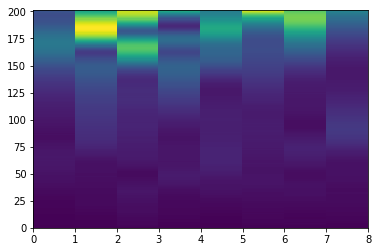

In [634]:
plt.subplots(1, 1, )
plt.pcolor(lorenz_gan_forecast_cube.std(axis=0))

In [508]:
np.percentile(lorenz_forecast_cube[:, :, x_val], 90, axis=0).shape

(201,)

In [413]:
with open("../exp/ar1_random_updater.pkl", "rb") as updater_file:
    updater = pickle.load(updater_file)

In [481]:
rand_values = np.random.normal(size=(8, 8))
all_rand_values = np.zeros((200, 8, 8))
all_rand_values[0] = rand_values
for i in range(1, 200):
    rand_values = updater.update(rand_values)
    all_rand_values[i] = rand_values

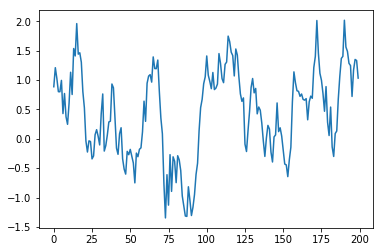

In [448]:
plt.plot(all_rand_values[:, 0, 4])

In [600]:
for i in range(10):
    print(i, pd.Series(all_rand_values[:, 0, 0]).autocorr(i))

0 1.0
1 0.900459091356
2 0.798332704409
3 0.715076477828
4 0.62945880385
5 0.537847495939
6 0.455850974727
7 0.362877812
8 0.268737670612
9 0.197284058567


In [582]:
pred_out_func = K.function(gen_model.input + [K.learning_phase()], [gen_model.output])
forcing_dist = np.zeros((1000, 8))
for i in range(1000):
    forcing_dist[i] = unnormalize_data(pred_out_func([x_vals[100000:100001].T, all_rand_values[0], True])[0], y_scaling)[:, :, 0].sum(axis=1)

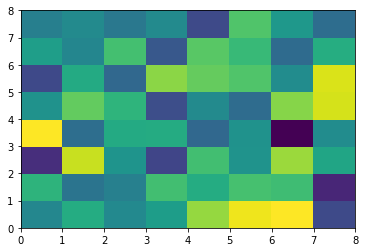

In [443]:
plt.pcolormesh(all_rand_values[1] - all_rand_values[0])

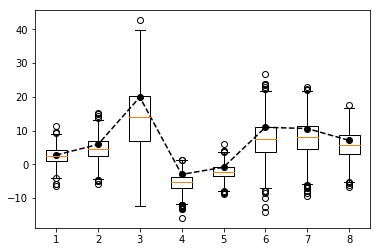

In [589]:
bx = plt.boxplot(forcing_dist)
plt.plot(np.arange(1, 9), x_vals[100000:100001].T, 'ko--')

In [468]:
print(x_vals[100000:100001,].T)

[[  2.72155571]
 [  5.86349964]
 [ 19.90745544]
 [ -3.03809571]
 [ -0.90208894]
 [ 10.94618988]
 [ 10.58712673]
 [  7.072505  ]]


In [12]:
train_data = pd.read_csv("../exp/lorenz_combined_output.csv")

In [13]:
train_data["U_t"] = train_data[train_data.columns[train_data.columns.str.contains("Y")]].sum(axis=1)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15         0.0
16         0.0
17         0.0
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         0.0
27         0.0
28         0.0
29         0.0
          ... 
1596770    7.0
1596771    7.0
1596772    7.0
1596773    7.0
1596774    7.0
1596775    7.0
1596776    7.0
1596777    7.0
1596778    7.0
1596779    7.0
1596780    7.0
1596781    7.0
1596782    7.0
1596783    7.0
1596784    7.0
1596785    7.0
1596786    7.0
1596787    7.0
1596788    7.0
1596789    7.0
1596790    7.0
1596791    7.0
1596792    7.0
1596793    7.0
1596794    7.0
1596795    7.0
1596796    7.0
1596797    7.0
1596798    7.0
1596799    7.0
Name: x_index, Length: 1596800, dtype: float64

In [51]:
train_data.loc[train_data["x_index"] == 3, ["U_t", "U_t-1"]]

,U_t,U_t-1
598800,1.329711,2.406654
598801,0.932690,1.329711
598802,0.761399,0.932690
598803,-0.148883,0.761399
598804,-2.133880,-0.148883
598805,-4.585677,-2.133880
598806,-6.661286,-4.585677
598807,-7.853603,-6.661286
598808,-8.169408,-7.853603
598809,-8.020258,-8.169408


(array([[    nan,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    279.,   1207.,    642.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    587.,   7317.,   3107.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    383.,  20888.,   4040.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    236.,  34119.,   2782.,
             nan,     nan,     nan],
        [    nan,     nan,     nan,     nan,    741.,  33578.,   3709.,
            120.,     nan,     nan],
        [    nan,     nan,     nan,     nan,   2345.,  19266.,   5058.,
            231.,     nan,     nan],
        [    nan,     nan,     nan,    126.,   2063.,   7793.,   3954.,
            527.,     nan,     nan],
        [    nan,     nan,     nan,    137.,    824.,   1606.,   1087.,
            299.,     nan,     nan],
        [    nan,  

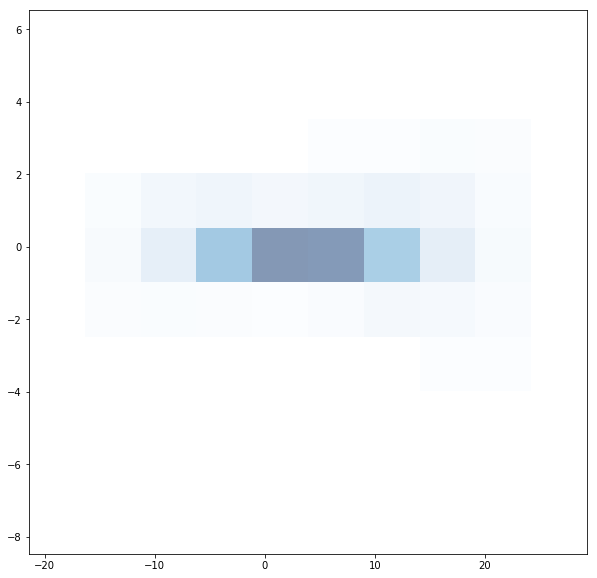

In [18]:
plt.figure(figsize=(10, 10))
plt.hist2d(train_data["X_t"], train_data["U_t-1"] - train_data["U_t"], cmin=100, cmap="Blues", alpha=0.5)


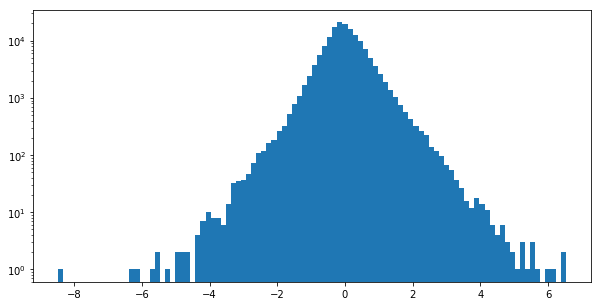

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.hist(train_data["U_t-1"] - train_data["U_t"], bins=100)
ax.set_yscale("log")

(array([[  1.,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ..., 
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,   1.]]),
 array([ -8.24566127,  -8.0018663 ,  -7.75807132,  -7.51427634,
         -7.27048137,  -7.02668639,  -6.78289141,  -6.53909644,
         -6.29530146,  -6.05150649,  -5.80771151,  -5.56391653,
         -5.32012156,  -5.07632658,  -4.8325316 ,  -4.58873663,
         -4.34494165,  -4.10114667,  -3.8573517 ,  -3.61355672,
         -3.36976174,  -3.12596677,  -2.88217179,  -2.63837681,
         -2.39458184,  -2.15078686,  -1.90699189,  -1.66319691,
         -1.41940193,  -1.17560696,  -0.93181198,  -0.688017  ,
         -0.44422203,  -0.20042705,   0.04336793,   0.2871629 ,
          0.53095788,   0.77475286,   1.01854783,   1.26234281,
          1.50613778,   1.74993276,   

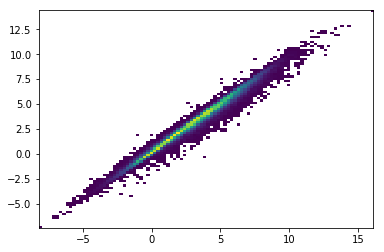

In [27]:
idx = (train_data["X_t"] >= 0) & (train_data["X_t"] < 5)
plt.hist2d(train_data.loc[idx, "U_t-1"], train_data.loc[idx, "U_t"], bins=100, cmin=1)